In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
data_filename = "./Data_2023_24/Train_DailyData.xlsx"
idx_filename = "./Data_2023_24/Train_IndexDailyData.xlsx"
weight_filename = "./Data_2023_24/stock_weight.csv"


In [3]:
stock_data = pd.read_excel(data_filename, header=[0,1], index_col=0, parse_dates=True)
index_data = pd.read_excel(idx_filename, header=[0,1], index_col=0, parse_dates=True)
wgt_data = pd.read_csv(weight_filename, index_col=0)


In [4]:
np.random.seed(24)

In [5]:
stock_close_px = stock_data.xs('close_px',axis=1, level=1)
rand_list = np.random.choice(stock_close_px.shape[1], size=20, replace=False)
selected_stock = sorted([c for i,c in enumerate(stock_close_px.columns) if i in rand_list])

stock_close_px = stock_close_px[selected_stock].copy()
print(selected_stock)

['STOCK_14', 'STOCK_15', 'STOCK_21', 'STOCK_27', 'STOCK_32', 'STOCK_38', 'STOCK_41', 'STOCK_49', 'STOCK_58', 'STOCK_59', 'STOCK_62', 'STOCK_68', 'STOCK_72', 'STOCK_76', 'STOCK_77', 'STOCK_81', 'STOCK_85', 'STOCK_87', 'STOCK_89', 'STOCK_95']


In [6]:
selected_index = ["Index_0","Index_5","Index_7","Index_8"]

idx_close_px = index_data.xs('close_px',axis=1, level=1)
selected_idx_close_px = idx_close_px[selected_index].copy()

In [7]:
print(stock_close_px.shape)
print(selected_idx_close_px.shape)

(972, 20)
(972, 4)


In [8]:
stock_close_px.head(2).append(stock_close_px.tail(2))

symbol      STOCK_14  STOCK_15  STOCK_21  STOCK_27  STOCK_32  STOCK_38  \
date                                                                     
2019-01-02    66.880     8.992    74.427    22.360    33.192    35.013   
2019-01-03    65.047     8.953    72.055    22.406    33.104    34.909   
2022-12-29   105.909    18.621    92.557    64.731    64.415    71.035   
2022-12-30   105.544    18.649    96.771    64.441    62.908    68.534   

symbol      STOCK_41  STOCK_49  STOCK_58  STOCK_59  STOCK_62  STOCK_68  \
date                                                                     
2019-01-02    76.883    58.691   179.598    44.168   429.595    63.355   
2019-01-03    75.088    54.078   174.427    44.602   424.181    62.437   
2022-12-29   114.384   209.998   369.218    44.543   205.317    50.353   
2022-12-30   117.335   208.591   375.709    45.063   206.308    50.640   

symbol      STOCK_72  STOCK_76  STOCK_77  STOCK_81  STOCK_85  STOCK_87  \
date                                                                     
2019-01-02   153.635   136.598    67.944    64.609     4.364    10.492   
2019-01-03   154.414   141.307    70.905    63.654     4.498    10.729   
2022-12-29   267.687   407.641   394.524   129.670     3.789     6.697   
2022-12-30   264.040   408.687   397.079   131.845     3.810     6.777   

symbol      STOCK_89  STOCK_95  
date                            
2019-01-02    40.997    35.253  
2019-01-03    39.187    35.484  
2022-12-29    51.480    67.688  
2022-12-30    51.760    67.761

### Index Return

In [9]:
indices_rets = selected_idx_close_px.pct_change()
indices_cumrets = indices_rets.add(1).cumprod().sub(1)*100

fig = px.line(indices_cumrets, x=indices_cumrets.index, y=indices_cumrets.columns, title='Cumulative Returns of Indices (2019-2022)')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')
fig.show()

### Stock Return

In [10]:
stock_close_returns = stock_close_px.pct_change()
stock_close_returns_cumprod = stock_close_returns.add(1).cumprod().sub(1)*100

fig = px.line(stock_close_returns_cumprod, x=stock_close_returns_cumprod.index, y=stock_close_returns_cumprod.columns, title='Cumulative Returns of Stocks (2019-2022)')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()

In [11]:
stock_close_returns_cumprod.iloc[-1].sort_values()[0:5]

symbol
STOCK_62   -51.976164
STOCK_87   -35.407930
STOCK_68   -20.069450
STOCK_85   -12.694775
STOCK_59     2.026354
Name: 2022-12-30 00:00:00, dtype: float64

In [12]:
stock_close_returns_cumprod.iloc[-1].sort_values(ascending=False)[0:5]

symbol
STOCK_77    484.420994
STOCK_49    255.405428
STOCK_76    199.189593
STOCK_27    188.197674
STOCK_58    109.194423
Name: 2022-12-30 00:00:00, dtype: float64

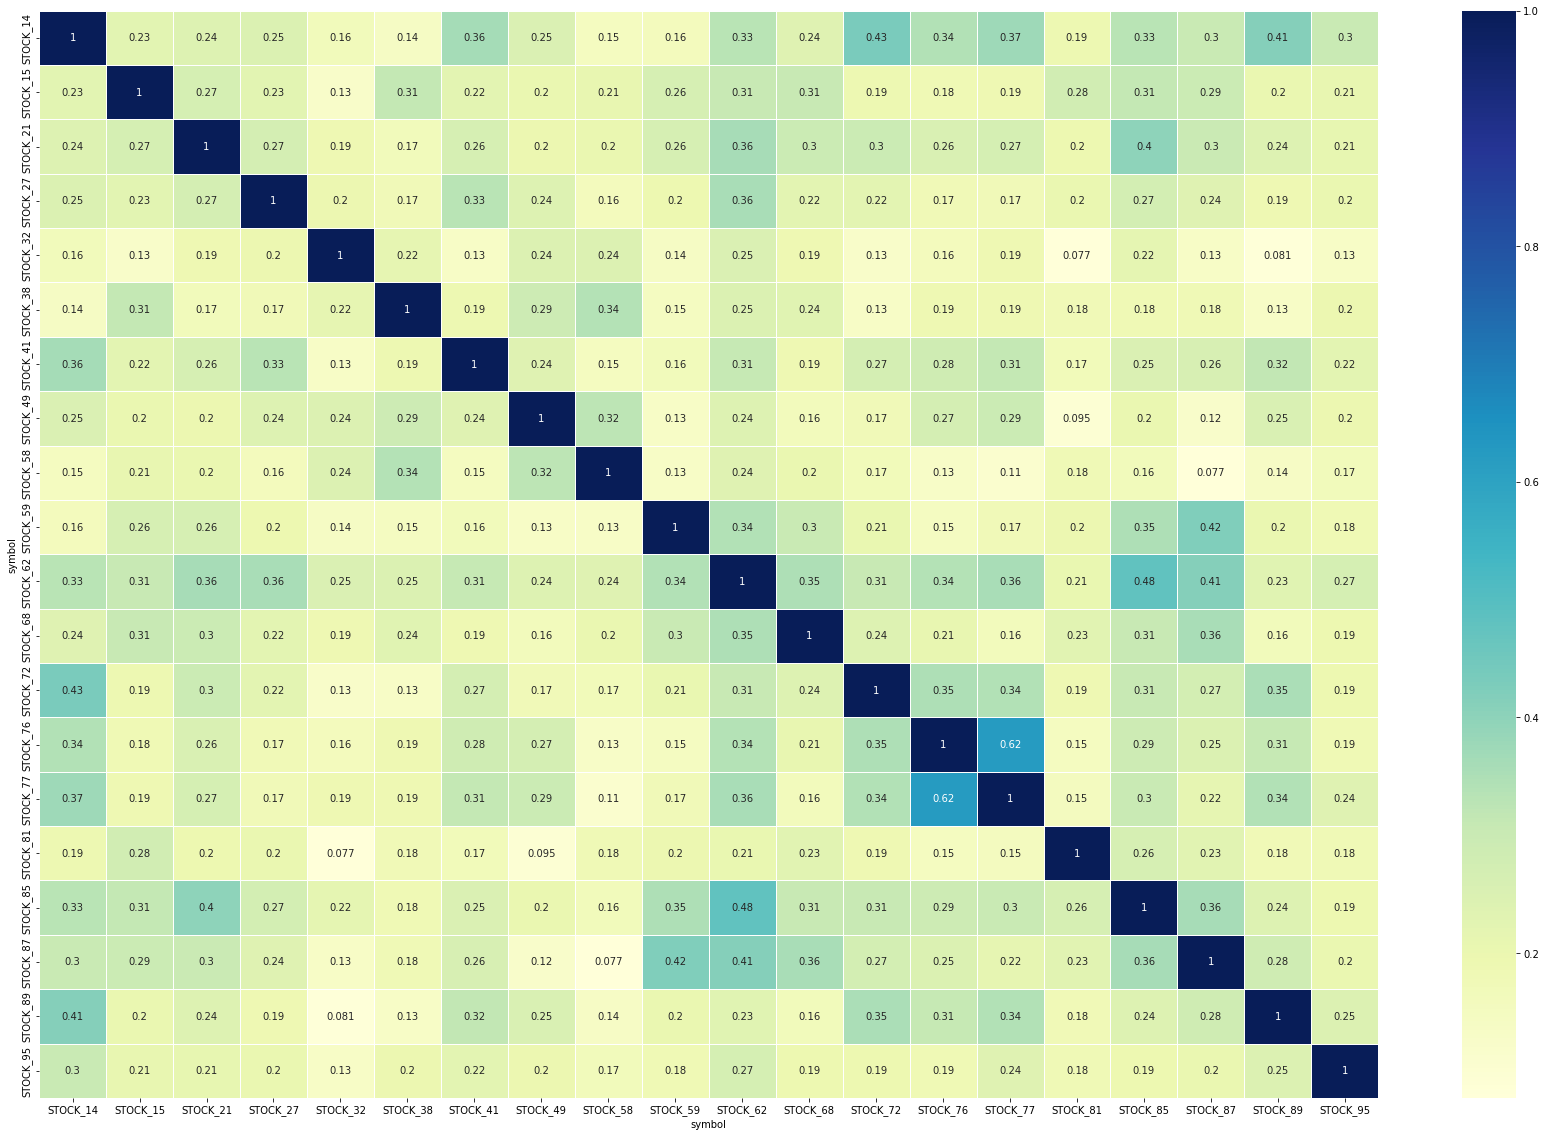

In [13]:
fig, ax = plt.subplots(figsize=(30, 20))
dataplot = sns.heatmap(stock_close_returns.corr(), cmap="YlGnBu", annot=True, linewidth=.5) 

### MVO

In [14]:

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA

In [15]:
train = stock_close_returns.loc[:dt.date(2022,1,1)]
test = stock_close_returns.loc[dt.date(2022,1,1):]

mu = expected_returns.ema_historical_return(train, returns_data = True, span = 500)
Sigma = risk_models.exp_cov(train, returns_data = True, span = 100)

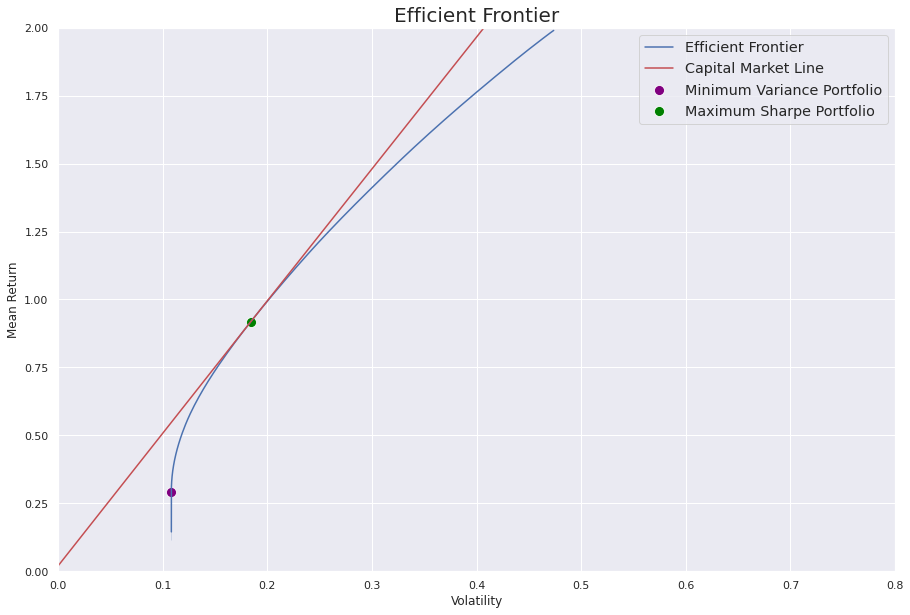

In [16]:
risk_free_rate=0.02

ret_ef = np.arange(0, 2, 0.01)
vol_ef = []
for i in np.arange(0, 2, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    ef.efficient_return(i)
    vol_ef.append(ef.portfolio_performance()[1])

ef = EfficientFrontier(mu, Sigma)
ef.min_volatility()
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]

ef = EfficientFrontier(mu, Sigma)
ef.max_sharpe(risk_free_rate=risk_free_rate)
max_sharpe_ret = ef.portfolio_performance()[0]
max_sharpe_vol = ef.portfolio_performance()[1]



sns.set()

fig, ax = plt.subplots(figsize = [15,10])

sns.lineplot(x = vol_ef, y = ret_ef, label = "Efficient Frontier", ax = ax)
sns.scatterplot(x = [min_vol_vol], y = [min_vol_ret], ax = ax, label = "Minimum Variance Portfolio", color = "purple", s = 100)
sns.scatterplot(x = [max_sharpe_vol], y = [max_sharpe_ret], ax = ax, label = "Maximum Sharpe Portfolio", color = "green", s = 100)


max_y_1 =(max_sharpe_ret-risk_free_rate)/max_sharpe_vol
sns.lineplot(x = [0, max_sharpe_vol, 1], y = [risk_free_rate, max_sharpe_ret, max_y_1], label = "Capital Market Line", ax = ax, color = "r")

ax.set(xlim = [0, 0.8])
ax.set(ylim = [0, 2])
ax.set_xlabel("Volatility")
ax.set_ylabel("Mean Return")
plt.legend(fontsize='large')
plt.title("Efficient Frontier", fontsize = '20')

ax.figure.savefig("EffFront_big.png", dpi = 300)

### Minimum variance portfolio

Expected annual return: 29.3%
Annual volatility: 10.8%
Sharpe Ratio: 2.62


(0.292709525652422, 0.10826140923286398, 2.6205970129409577)

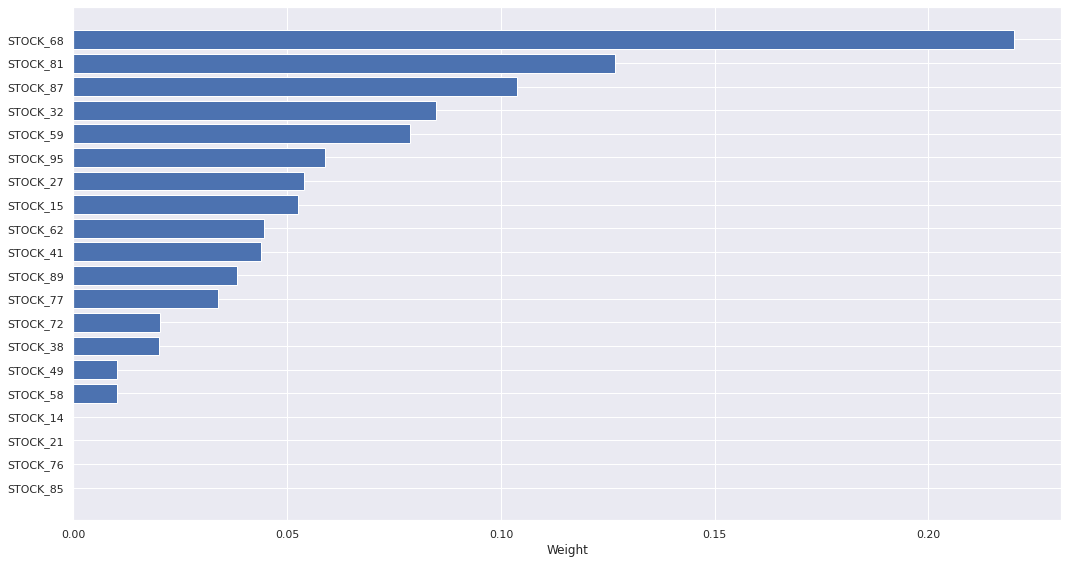

In [17]:
ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()


fig, ax = plt.subplots(figsize = [15,8])
plot_weights(raw_weights_minvar_exp, fig=fig)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

### Maximum Sharpe Portfolio

Expected annual return: 90.2%
Annual volatility: 18.1%
Sharpe Ratio: 4.94


(0.9019396151638098, 0.180844360569474, 4.937613826341983)

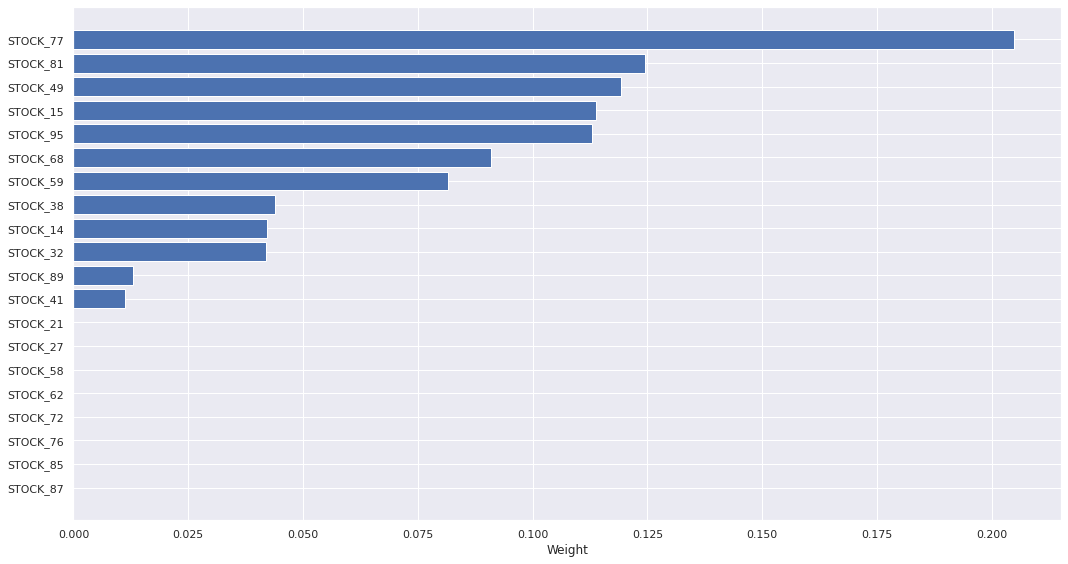

In [18]:
ef = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe_exp = ef.max_sharpe(risk_free_rate=0.009)

fig, ax = plt.subplots(figsize = [15,8])
plot_weights(raw_weights_maxsharpe_exp, fig=fig)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

### Backtesting

In [19]:
weights_minvar_exp = list(raw_weights_minvar_exp.values())
weights_maxsharpe_exp = list(raw_weights_maxsharpe_exp.values())

ret_1 = test.dot(weights_minvar_exp).add(1).cumprod().subtract(1).multiply(100)
ret_2 = test.dot(weights_maxsharpe_exp).add(1).cumprod().subtract(1).multiply(100)

ind_ret = selected_idx_close_px.loc[dt.date(2022,1,1):].pct_change().add(1).cumprod().subtract(1).multiply(100)

back = pd.DataFrame({"MinVar":ret_1, "MaxSharpe":ret_2})
back = pd.concat([back, ind_ret],  join = "outer", axis = 1)

In [20]:

fig = px.line(back, x = back.index, y = back.columns, title = "Portfolio Performance (2022)")
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()